In [1]:
import os
os.environ["STELLARMODELS"] = "../fs255_grid/"


import sys
sys.path.insert(0,'../src/')
import mors

%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

import numpy as np
import matplotlib.pyplot as plt 



In [2]:
# Mstar = 1.0
# pctle = 1.0
# spec_file = "../../input/spec_sun.txt"

# Mstar = 0.181
# pctle = 50.0
# age   = 4e3
# spec_file = "../../input/spec_gj1214.txt"

Mstar = 0.82
pctle = 1.0
age   = 400.0
spec_file = "../../input/spec_v-eps-eri.txt"

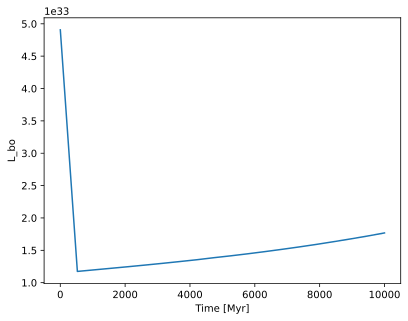

In [3]:
t_arr = np.linspace(1, 10000, 20)
v_arr = []
prop = "L_bo"

for t in t_arr:
    v = mors.synthesis.GetProperties(Mstar, pctle, t)[prop]
    v_arr.append(v)

fig,ax = plt.subplots(1,1)

ax.plot(t_arr,v_arr)
ax.set(xlabel="Time [Myr]", ylabel=prop)

plt.show()

In [4]:
# modern = mors.synthesis.GetProperties(Mstar, pctle, t_arr[-1])

# fig,ax = plt.subplots(1,1)


# for prop in ["Q_bo","Q_xr","Q_pl"]:

#     v_arr = []
#     for t in t_arr:
#         v = mors.synthesis.CalcBandScales(modern, t)[prop]
#         v_arr.append(v)

#     ax.plot(t_arr,v_arr, label=prop)


# ax.set(xlabel="Time [Myr]", ylabel="Scale factor")
# ax.legend()
# plt.show()

From file: {'xr': 5.560306506232015, 'e1': 7.9448154085, 'e2': 12.0609833475, 'uv': 19812.444715437763, 'pl': 408738.2618259645, 'bo': 428584.7014739761}
Spec xr : 5.863e-01 erg s-1 cm-2 nm-1
Spec e1 : 3.611e-01 erg s-1 cm-2 nm-1
Spec e2 : 2.010e-01 erg s-1 cm-2 nm-1
Spec uv : 6.433e+01 erg s-1 cm-2 nm-1
Spec pl : 4.087e-04 erg s-1 cm-2 nm-1
{'mass': 0.82, 'pctle': 1.0, 'age': 400.0, 'radius': 505766470.19332194, 'Teff': 5023.6501912927915, 'L_bo': 1.1672905565321655e+33, 'L_xr': 1.4824584314677367e+28, 'L_e1': 2.53633822941637e+28, 'L_e2': 7.912967626346741e+27, 'F_bo': 415055.2589806584, 'F_xr': 5.271199743351534, 'F_e1': 9.018495992980712, 'F_e2': 2.8136258012881563, 'F_pl': 384666.2440438144, 'L_pl': 1.0818252856060456e+33, 'F_uv': 30371.91161530628, 'L_uv': 8.541716999188466e+31}
Mors xr : 5.559e-01 erg s-1 cm-2 nm-1
    surf = 2.437e+05 erg s-1 cm-2
Mors e1 : 4.099e-01 erg s-1 cm-2 nm-1
    surf = 4.170e+05 erg s-1 cm-2
Mors e2 : 4.689e-02 erg s-1 cm-2 nm-1
    surf = 1.301e+05 e

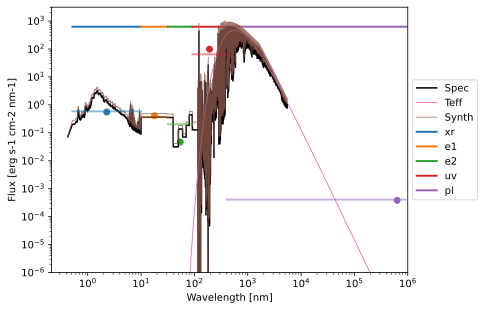

In [5]:
modern = mors.spec.Spectrum()
modern.LoadTSV(spec_file)
# modern.ExtendShortwave(0.01)
# modern.ExtendPlanck(3111, 0.208*mors.const.Rsun*1.0e-2,  1.0e5)

bands = mors.spec.bands_ascending
bcols = ["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:cyan"]

fig,ax = plt.subplots(1,1)

# Modern spectrum
ax.plot(modern.wl, modern.fl, label="Spec", c='black')

# Integrated fluxes
modern.CalcBandFluxes()
print("From file:",modern.fl_integ)
for i,k in enumerate(bands):
    lim = mors.spec.bands_limits[k]
    wid = lim[1]-lim[0]
    y = modern.fl_integ[k]/wid
    print("Spec %s : %.3e erg s-1 cm-2 nm-1"%(k,y))
    ax.plot(lim,[y,y], c=bcols[i], zorder=3, lw=2, alpha=0.5)

# MORS fluxes
props = mors.synthesis.GetProperties(Mstar, pctle, age)
print(props)
for i,k in enumerate(bands):
    lim = mors.spec.bands_limits[k]
    wid = lim[1]-lim[0]
    y = props["F_"+k]/wid
    x = 10.0**np.median(np.log10(lim))
    
    print("Mors %s : %.3e erg s-1 cm-2 nm-1"%(k,y))
    surf = props["F_"+k] * (mors.const.AU/mors.const.Rsun)**2
    print("    surf = %.3e erg s-1 cm-2"%surf)

    ax.scatter([x], [y], c=bcols[i])

# Planck function at Teff
pf_x = np.logspace(1, 6, 300)
pf_y = mors.spec.PlanckFunction_surf(pf_x, props["Teff"])
pf_y = mors.spec.ScaleTo1AU(pf_y, props["radius"])
integ = np.trapz(pf_y, pf_x)
ax.plot(pf_x, pf_y, label="Teff", color='tab:pink', lw=0.9)

# Scaled spectrum
synthetic = mors.synthesis.CalcScaledSpectrumFromProps(modern, props, 1e4)
ax.plot(synthetic.wl, synthetic.fl, color='tab:brown', lw=0.9, label="Synth", alpha=0.8)

# Band intervals 
for i,k in enumerate(bands):
    if k == "bo":
        continue 
    lim = mors.spec.bands_limits[k]
    y = np.amax(modern.fl)
    ax.plot(lim,[y,y], label=k, c=bcols[i], lw=2, zorder=-1)

# Decorate 
ax.set(xscale="log", xlabel="Wavelength [nm]")
ax.set(yscale="log", ylabel="Flux [erg s-1 cm-2 nm-1]")
ax.set_xlim(modern.wl[0]*0.5, 1e6)
ax.set_ylim(bottom=1e-6, top=np.amax(modern.fl)*5)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()